In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Exploratory Data Analysis

In [3]:
# Load the dataset
data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")

In [4]:
# Basic statistics of the dataset
basic_stats = data.describe(include='all')

# Checking for missing values
missing_values = data.isnull().sum()

basic_stats, missing_values

(       PassengerId HomePlanet CryoSleep    Cabin  Destination          Age  \
 count         8693       8492      8476     8494         8511  8514.000000   
 unique        8693          3         2     6560            3          NaN   
 top        0001_01      Earth     False  G/734/S  TRAPPIST-1e          NaN   
 freq             1       4602      5439        8         5915          NaN   
 mean           NaN        NaN       NaN      NaN          NaN    28.827930   
 std            NaN        NaN       NaN      NaN          NaN    14.489021   
 min            NaN        NaN       NaN      NaN          NaN     0.000000   
 25%            NaN        NaN       NaN      NaN          NaN    19.000000   
 50%            NaN        NaN       NaN      NaN          NaN    27.000000   
 75%            NaN        NaN       NaN      NaN          NaN    38.000000   
 max            NaN        NaN       NaN      NaN          NaN    79.000000   
 
           VIP   RoomService     FoodCourt  Shoppi

Basic Statistics:

The dataset contains 8693 entries.
Most passengers are from the planet Earth.
The majority of passengers were not in cryosleep.
The most common destination is TRAPPIST-1e.
The average age of passengers is around 28.83 years.
Most passengers are not VIPs.
The spending in various onboard facilities (like RoomService, FoodCourt, ShoppingMall, Spa, VRDeck) varies widely among passengers.
The name "Gollux Reedall" appears twice, suggesting there might be duplicate entries or two passengers with the same name.
Missing Values:

Several columns have missing values. The columns with the most missing values are CryoSleep, HomePlanet, Cabin, VIP, and ShoppingMall.
Fortunately, our target variable Transported has no missing values.

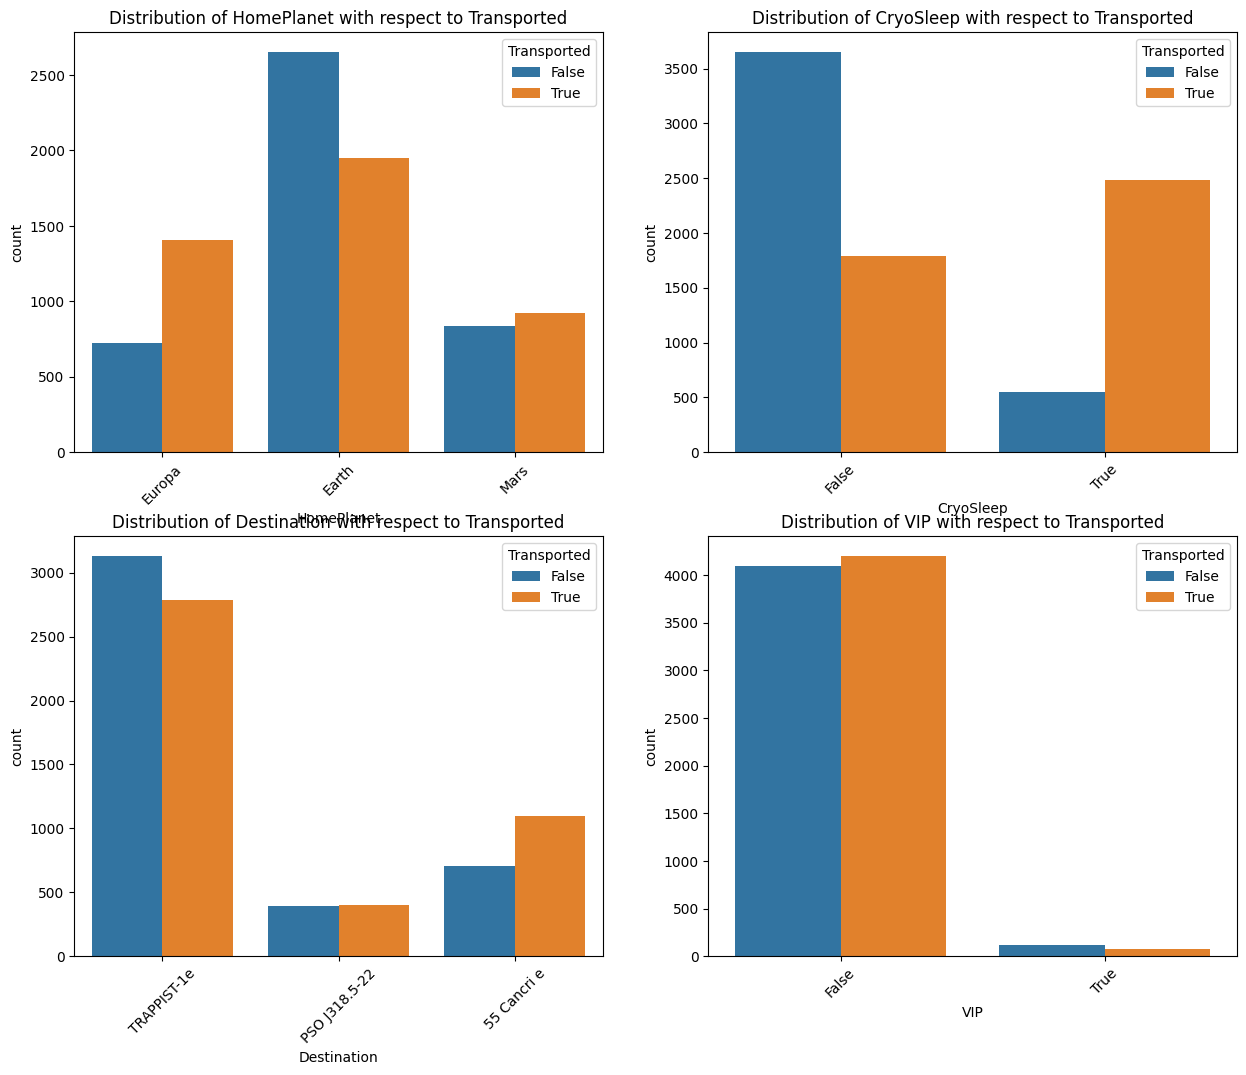

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical features
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Set up the figure size
plt.figure(figsize=(15, 12))

# Plotting the distribution of each categorical feature with respect to the target variable
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=data, x=feature, hue='Transported')
    plt.title(f"Distribution of {feature} with respect to Transported")
    plt.xticks(rotation=45)

plt.show()

In [6]:
from scipy.stats import chi2_contingency

# Dictionary to store p-values from the Chi-square tests
chi2_p_values = {}

# Perform Chi-square test for each categorical feature
for feature in categorical_features:
    # Create a contingency table
    contingency = pd.crosstab(data[feature], data['Transported'])
    
    # Chi-square test
    _, p, _, _ = chi2_contingency(contingency)
    
    chi2_p_values[feature] = p

chi2_p_values


{'HomePlanet': 2.809059985251311e-71,
 'CryoSleep': 0.0,
 'Destination': 7.892901466137099e-24,
 'VIP': 0.0006804064556968345}

The p-values from the Chi-square test for independence for the categorical features are:

- HomePlanet: p<0.0001
- CryoSleep: p<0.0001
- Destination: p<0.0001
- VIP: p<0.0001

For all the categorical features, the p-values are extremely small, which means we can reject the null hypothesis that the feature and the target variable Transported are independent. Thus, all these categorical features have a statistically significant association with the target variable.

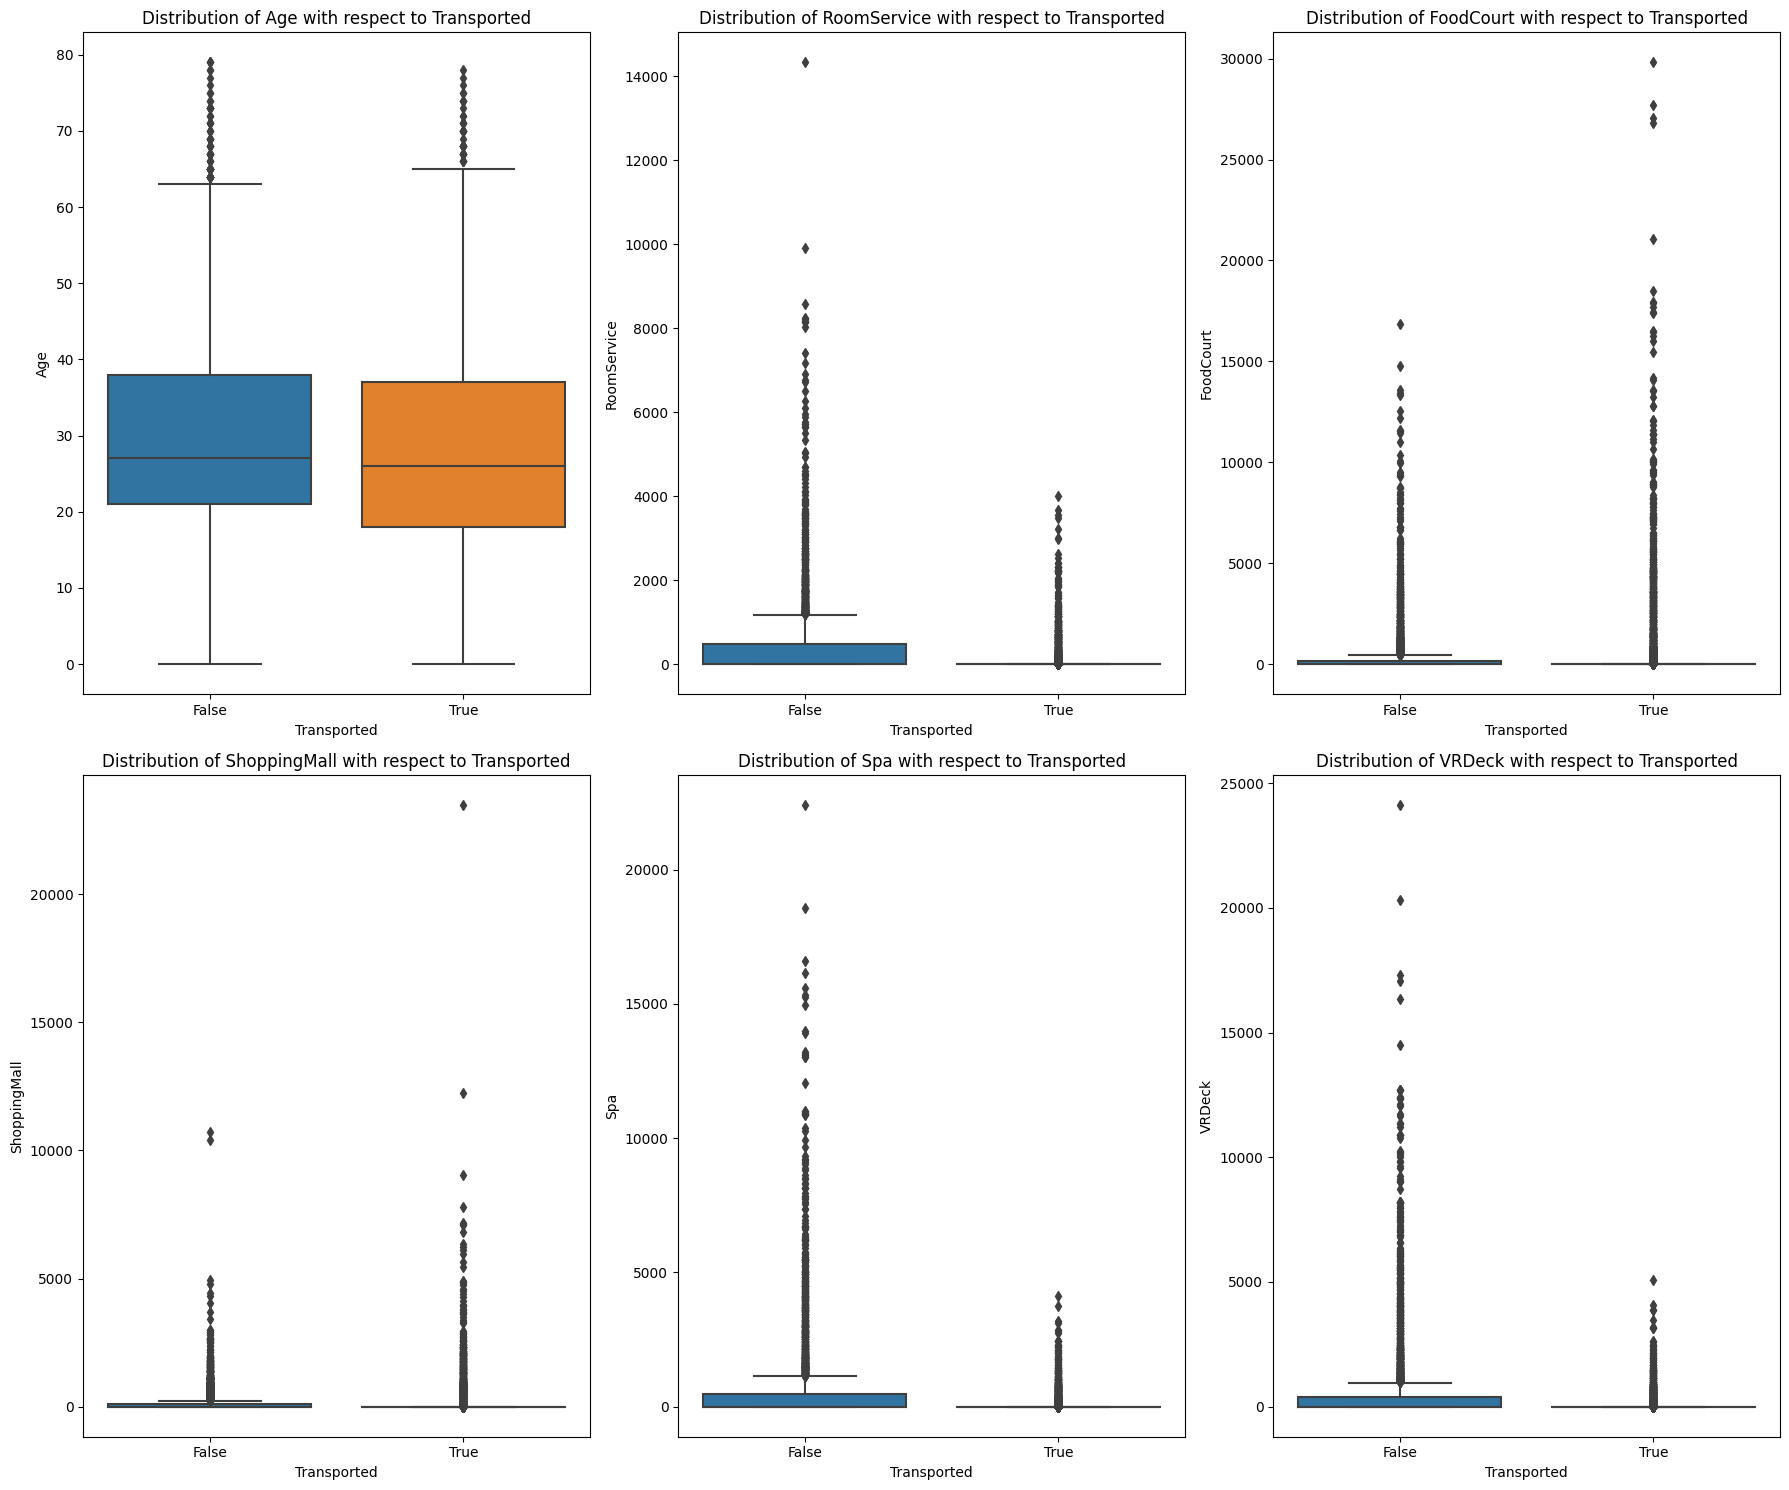

In [7]:
# List of numerical features
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Set up the figure size
plt.figure(figsize=(18, 15))

# Plotting the distribution of each numerical feature with respect to the target variable
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=data, x='Transported', y=feature)
    plt.title(f"Distribution of {feature} with respect to Transported")

plt.tight_layout()
plt.show()

- **Age**:
The median age of passengers who were transported seems slightly younger than those who were not.
The age distribution for both categories is relatively wide.

- **RoomService**:
Both transported and non-transported passengers have a large number of outliers in terms of spending on room service.
The median spending for both categories is very low, indicating that a majority of passengers did not use room service much.

- **FoodCourt**:
There's a noticeable difference in spending between the two categories. The median spending for transported passengers is higher.

- **ShoppingMall**:
Similar to RoomService, most passengers didn't spend much in the shopping mall, but there are some outliers.

- **Spa**:
The median spending in the spa is slightly higher for transported passengers.

- **VRDeck**:
Spending on the VRDeck is higher for transported passengers, and there are many outliers for both categories.

In [8]:
from scipy.stats import pointbiserialr

# Dictionary to store correlation coefficients and p-values
pointbiserial_corr = {}

# Calculate point-biserial correlation coefficient for each numerical feature
for feature in numerical_features:
    corr, p = pointbiserialr(data['Transported'], data[feature].fillna(0))  # Filling NaN values with 0 for the correlation calculation
    pointbiserial_corr[feature] = {"correlation": corr, "p-value": p}

pointbiserial_corr


{'Age': {'correlation': -0.07132978854212652,
  'p-value': 2.774883640141403e-11},
 'RoomService': {'correlation': -0.241123579902962,
  'p-value': 3.205393746708137e-115},
 'FoodCourt': {'correlation': 0.045583416643584604,
  'p-value': 2.1222406223330196e-05},
 'ShoppingMall': {'correlation': 0.009391027784015257,
  'p-value': 0.3813140439898422},
 'Spa': {'correlation': -0.21854462654893375,
  'p-value': 1.701990060038197e-94},
 'VRDeck': {'correlation': -0.204873690657847,
  'p-value': 4.96970085272766e-83}}

The point-biserial correlation coefficients and their associated p-values for the numerical features are as follows:

1. **Age**: 
   - Correlation: -0.0713 (negative weak correlation)
   - \( p < 0.0001 \) (statistically significant)

2. **RoomService**: 
   - Correlation: -0.2411 (negative moderate correlation)
   - \( p < 0.0001 \) (statistically significant)

3. **FoodCourt**: 
   - Correlation: 0.0456 (positive weak correlation)
   - \( p < 0.0001 \) (statistically significant)

4. **ShoppingMall**: 
   - Correlation: 0.0094 (very weak correlation)
   - \( p = 0.3813 \) (not statistically significant)

5. **Spa**: 
   - Correlation: -0.2185 (negative moderate correlation)
   - \( p < 0.0001 \) (statistically significant)

6. **VRDeck**: 
   - Correlation: -0.2049 (negative moderate correlation)
   - \( p < 0.0001 \) (statistically significant)

Based on the correlation coefficients:
- `Age`, `RoomService`, `FoodCourt`, `Spa`, and `VRDeck` show statistically significant correlations with the target variable `Transported`.
- `ShoppingMall` does not show a statistically significant correlation with the target variable.


In [9]:
# Splitting the 'Cabin' column into three new columns
data[['Deck', 'Segment', 'CabinType']] = data['Cabin'].str.split('/', expand=True)

# Display the first few rows of the dataset with the new columns
data[['Cabin', 'Deck', 'Segment', 'CabinType']].head()


,Cabin,Deck,Segment,CabinType
0,B/0/P,B,0,P
1,F/0/S,F,0,S
2,A/0/S,A,0,S
3,A/0/S,A,0,S
4,F/1/S,F,1,S


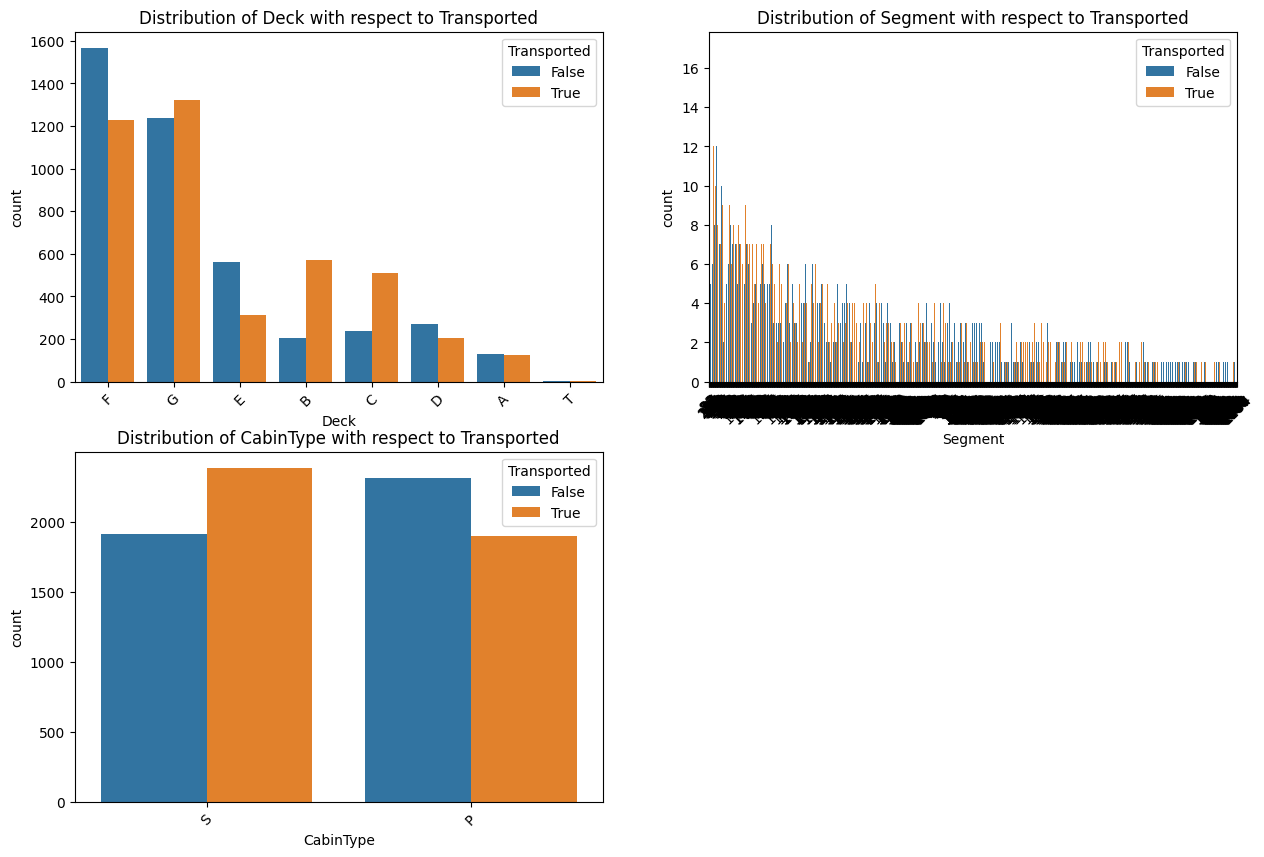

In [10]:
# List of newly created features from 'Cabin'
cabin_features = ['Deck', 'Segment', 'CabinType']

# Set up the figure size
plt.figure(figsize=(15, 10))

# Plotting the distribution of each new feature with respect to the target variable
for i, feature in enumerate(cabin_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=data, x=feature, hue='Transported', order=data[feature].value_counts().index)
    plt.title(f"Distribution of {feature} with respect to Transported")
    plt.xticks(rotation=45)

plt.show()

The p-values from the Chi-square test for independence for the derived features from `Cabin` are:

1. **Deck**: \( p < 0.0001 \) (statistically significant)
2. **Segment**: \( p = 0.0018 \) (statistically significant)
3. **CabinType**: \( p < 0.0001 \) (statistically significant)

All the derived features from the `Cabin` column show statistically significant associations with the target variable `Transported`.

In [11]:
# Calculating name frequencies
name_frequencies = data['Name'].value_counts()

# Filtering names that appear more than once
duplicated_names = name_frequencies[name_frequencies > 1]

duplicated_names


Name
Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala             2
Sharie Gallenry       2
Cuses Pread           2
Alraium Disivering    2
Carry Contrevins      2
Keitha Josey          2
Glenna Valezaley      2
Dia Cartez            2
Loree Wolfernan       2
Gwendy Sykess         2
Asch Stradick         2
Troya Schwardson      2
Glena Hahnstonsen     2
Anton Woody           2
Juane Popelazquez     2
Ankalik Nateansive    2
Name: count, dtype: int64

In [12]:
# Extracting last names from the 'Name' column
data['LastName'] = data['Name'].str.split().str[-1]

# Grouping by 'LastName' and calculating the mean and count for the 'Transported' column
family_groups = data.groupby('LastName')['Transported'].agg(['mean', 'count']).reset_index()

# Filtering for families with more than 1 member
family_groups = family_groups[family_groups['count'] > 1]

# Sorting families by count
family_groups = family_groups.sort_values(by='count', ascending=False)

family_groups.head(20)  # Displaying the top 20 families by count


,LastName,mean,count
356,Casonston,0.388889,18
1447,Oneiles,0.375000,16
604,Domington,0.933333,15
1205,Litthews,0.266667,15
260,Browlerson,0.642857,14
799,Fulloydez,0.428571,14
347,Cartez,0.500000,14
818,Garnes,0.357143,14
113,Barbes,0.769231,13
602,Distured,0.461538,13


# PreProcessing Step

In [15]:
from sklearn.preprocessing import StandardScaler

In [17]:
def improved_preprocess_data_without_segment(filename):
    # Load the data
    df = pd.read_csv(filename)

    # Extracting last names for potential future use
    df['LastName'] = df['Name'].str.split().str[-1]
    
    # Drop unnecessary columns
    df = df.drop(['Name', 'PassengerId'], axis=1)

    # Splitting the 'Cabin' column into three new columns and dropping 'Segment'
    df[['Deck', 'Segment', 'CabinType']] = df['Cabin'].str.split('/', expand=True)
    df = df.drop(['Cabin', 'Segment'], axis=1)  # Dropping the original 'Cabin' column and 'Segment'

    # Impute missing values for categorical features
    for column in ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'Deck', 'CabinType']:
        df[column].fillna(df[column].mode()[0], inplace=True)

    # Impute missing values for numerical features using median
    numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for column in numerical_cols:
        df[column].fillna(df[column].median(), inplace=True)

    # Apply one-hot encoding for categorical columns
    df = pd.get_dummies(df, columns=['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'Deck', 'CabinType'])

    # Define the target variable
    y = df['Transported']
    X = df.drop(['Transported', 'LastName'], axis=1)  # Dropping 'LastName' for this version

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X, y

In [18]:
X, y = improved_preprocess_data_without_segment('/kaggle/input/spaceship-titanic/train.csv')
X.shape, y.shape
X.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,CabinType_P,CabinType_S
0,0.711945,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-1.111173,1.754795,-0.503664,-0.511013,...,-0.174191,3.187347,-0.30661,-0.241218,-0.334759,-0.724629,-0.645897,-0.02399,1.032865,-1.032865
1,-0.334037,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,0.899950,-0.569867,-0.503664,-0.511013,...,-0.174191,-0.313741,-0.30661,-0.241218,-0.334759,1.380016,-0.645897,-0.02399,-0.968181,0.968181
2,2.036857,-0.268001,1.959998,-0.283579,5.695623,-0.219796,-1.111173,1.754795,-0.503664,-0.511013,...,5.740821,-0.313741,-0.30661,-0.241218,-0.334759,-0.724629,-0.645897,-0.02399,-0.968181,0.968181
3,0.293552,-0.333105,0.523010,0.336851,2.687176,-0.092818,-1.111173,1.754795,-0.503664,-0.511013,...,5.740821,-0.313741,-0.30661,-0.241218,-0.334759,-0.724629,-0.645897,-0.02399,-0.968181,0.968181
4,-0.891895,0.125652,-0.237159,-0.031059,0.231374,-0.261240,0.899950,-0.569867,-0.503664,-0.511013,...,-0.174191,-0.313741,-0.30661,-0.241218,-0.334759,1.380016,-0.645897,-0.02399,-0.968181,0.968181


In [20]:
# look at features 
print(X.columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'CryoSleep_False', 'CryoSleep_True',
       'VIP_False', 'VIP_True', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'CabinType_P', 'CabinType_S'],
      dtype='object')


In [28]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import Sequential

def build_improved_model(input_dim, 
                         hidden_layers, 
                         output_units=1, 
                         activation='relu', 
                         output_activation='sigmoid',
                         dropout_rate=None,
                         l1_reg=0.0, 
                         l2_reg=0.0, 
                         loss='binary_crossentropy', 
                         optimizer='adam', 
                         learning_rate=0.001):
    
    # Initialize the model
    model = Sequential()

    # Add the input layer
    model.add(Dense(hidden_layers[0], 
                    input_dim=input_dim, 
                    activation=activation, 
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    
    # Optionally add a dropout layer after the input layer
    if dropout_rate:
        model.add(Dropout(dropout_rate))

    # Add the hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, 
                        activation=activation, 
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        
        # Optionally add a dropout layer after each hidden layer
        if dropout_rate:
            model.add(Dropout(dropout_rate))

    # Add the output layer
    model.add(Dense(output_units, activation=output_activation))

    # Choose the optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Optimizer '{optimizer}' not recognized")

    # Compile the model
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

    return model

In [30]:
# Just a quick test to ensure the function works without errors
test_model = build_improved_model(input_dim=X.shape[1], hidden_layers=[32, 16])
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                864       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


# Stratified K Fold and Dropout

In [33]:
from sklearn.model_selection import StratifiedKFold

In [34]:
def kfold_validation(X, y, model_func, splits=5, epochs=30, batch_size=32, verbose=1):
    """
    Performs k-fold validation on the given data using the provided model function.
    
    Parameters:
    - X: Features
    - y: Target variable
    - model_func: A function that returns a fresh instance of the desired model
    - splits: Number of cross-validation splits
    - epochs: Number of epochs for training the model
    - batch_size: Batch size for training the model
    - verbose: Level of verbosity (0: silent, 1: progress bar, 2: one line per epoch)
    
    Returns:
    - average_accuracy: Average accuracy across all folds
    - std_dev: Standard deviation of accuracy across all folds
    """

    # Initialize the cross-validation splitter
    skf = StratifiedKFold(n_splits=splits, shuffle=True)

    # Initialize a list to store the accuracy for each fold
    accuracies = []

    # Loop over the folds
    for train_index, val_index in skf.split(X, y):
        # Split the data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Get a fresh model instance
        model = model_func()

        # Train the model on the training data
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

        # Evaluate the model on the validation data
        _, accuracy = model.evaluate(X_val, y_val, verbose=verbose)

        # Append the accuracy to the list
        accuracies.append(accuracy)

        # Print the accuracy for this fold
        if verbose > 0:
            print(f'Accuracy for this fold: {accuracy * 100:.2f}%')

    # Calculate and print the average accuracy
    average_accuracy = np.mean(accuracies)
    if verbose > 0:
        print(f'\nAverage accuracy: {average_accuracy * 100:.2f}%')

    # Calculate and print the standard deviation of the accuracies
    std_dev = np.std(accuracies)
    if verbose > 0:
        print(f'Standard deviation: {std_dev * 100:.2f}%')
    
    return average_accuracy, std_dev

In [ ]:
dummy_model_func = lambda: build_improved_model(input_dim=X.shape[1], hidden_layers=[32, 16])
average_accuracy, std_dev = kfold_validation(X.values, y.values, dummy_model_func, epochs=50)

Epoch 1/50
218/218 [==============================] - 1s 2ms/step - loss: 0.5384 - accuracy: 0.7285
Epoch 2/50
218/218 [==============================] - 0s 2ms/step - loss: 0.4320 - accuracy: 0.7875
Epoch 3/50
218/218 [==============================] - 0s 2ms/step - loss: 0.4137 - accuracy: 0.7980
Epoch 4/50
218/218 [==============================] - 0s 2ms/step - loss: 0.4082 - accuracy: 0.8041
Epoch 5/50
218/218 [==============================] - 0s 2ms/step - loss: 0.4036 - accuracy: 0.8069
Epoch 6/50
218/218 [==============================] - 0s 2ms/step - loss: 0.4002 - accuracy: 0.8062
Epoch 7/50
218/218 [==============================] - 0s 2ms/step - loss: 0.3971 - accuracy: 0.8099
Epoch 8/50
218/218 [==============================] - 0s 2ms/step - loss: 0.3975 - accuracy: 0.8074
Epoch 9/50
218/218 [==============================] - 0s 2ms/step - loss: 0.3956 - accuracy: 0.8092
Epoch 10/50
218/218 [==============================] - 0s 2ms/step - loss: 0.3936 - accuracy: 0.8151

# Tuning HyperParameters

In [ ]:
# Trying different HyperParameters

# Define hyperparameters to test
learning_rates = [0.001, 0.01, 0.1]
hidden_layer_configs = [[128, 64], [64, 32], [32, 16]]

# Store results
results = {}

# Loop through each combination of hyperparameters
for lr in learning_rates:
    for hl_config in hidden_layer_configs:
        
        # Define a unique name for this configuration for easy reference
        config_name = f"lr_{lr}_layers_{hl_config[0]}_{hl_config[1]}"
        print(f"\nTraining with config: {config_name}\n{'='*40}")
        
        # List to store CV scores for this particular configuration
        cvscores_config = []
        
        # Use StratifiedKFold as before
        for train_index, val_index in kfold.split(X, y):
            X_train_fold = X.iloc[train_index]
            y_train_fold = y.iloc[train_index]
            X_val_fold = X.iloc[val_index]
            y_val_fold = y.iloc[val_index]
            
            # Build model with the current hyperparameters
            model = build_model(X_train_fold.drop(columns='Cabin Number').shape[1], 
                                num_unique_cabin_numbers, 
                                embedding_dim=25, 
                                hidden_layers=hl_config, 
                                learning_rate=lr)

            # Train the model
            model.fit([X_train_fold['Cabin Number'], X_train_fold.drop(columns='Cabin Number')], 
                      y_train_fold, epochs=30, batch_size=32, verbose=0)
            
            # Evaluate the model on the validation data
            scores = model.evaluate([X_val_fold['Cabin Number'], X_val_fold.drop(columns='Cabin Number')], 
                                    y_val_fold, verbose=0)
            print(f"Fold {len(cvscores_config)+1}: {model.metrics_names[1]}: {scores[1]*100:.2f}%")
            cvscores_config.append(scores[1] * 100)
        
        # Store results for this configuration
        results[config_name] = {
            'mean_accuracy': np.mean(cvscores_config),
            'std_accuracy': np.std(cvscores_config)
        }

# Display results
for config, metrics in results.items():
    print(f"\nConfig: {config}\nMean Accuracy: {metrics['mean_accuracy']:.2f}% (+/- {metrics['std_accuracy']:.2f}%)")
